In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import easy_coloc

In [2]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [3]:
def distance_between_stations(lat,lon):
    
    count=0

    dx = np.zeros(lat.shape)

    for lat_i,lon_i in zip(lat.values[1:],lon.values[1:]):

        dx[count+1] = haversine(lon.values[count], lat.values[count], lon_i, lat_i)

        count += 1
        
    return dx

In [4]:
def section_lenth(lat,lon):
    
    dx = distance_between_stations(lat,lon)
    
    return np.cumsum(dx)

In [5]:
def identify_breaks(lat,lon,thresh=120):
    
    dx = distance_between_stations(lat,lon)
    
    tem = pd.DataFrame({'dx':np.ravel(dx)},index=lon.index)
#     break_inds = tem[tem.dx > np.percentile(tem.dx,pct)].index.values
    break_inds = tem[tem.dx > thresh].index.values    
    return break_inds

In [6]:
def clean_section(lat,lon,thresh=120):
    
    break_inds = identify_breaks(lat,lon,thresh)
#     lat = lat.reset_index()
#     lon = lon.reset_index()

    return lat.drop(break_inds-1).reset_index().drop('index', axis=1),lon.drop(break_inds-1).reset_index().drop('index', axis=1)

In [7]:
lineid=171

In [8]:
glodap = pd.read_csv('GLODAPv2.2019_WOCE_GOSHIP.csv')

In [9]:
expc = pd.read_csv('FILTERED_GLODAP_EXPOCODE.csv')

In [10]:
expc[expc['ID']==lineid]

,Unnamed: 0,ID,EXPOCODE,LINE
26,170,171,18HU20080520,AR07 AR07W


In [11]:
coords = pd.DataFrame()

for cruise_id in expc['ID']:

    cruise = glodap[glodap['cruise']==cruise_id]
    lat = cruise.groupby('station').mean()['latitude']
    lon = cruise.groupby('station').mean()['longitude']
    cid = cruise.groupby('station').mean()['cruise']
    tem = pd.concat([cid,lat,lon],axis=1).reset_index()
    coords = pd.concat([coords,tem])

In [12]:
coords = coords.reset_index().drop('index', axis=1)

In [13]:
lat = coords[coords.cruise == lineid].latitude
lon = coords[coords.cruise == lineid].longitude

dx = distance_between_stations(lat,lon)
break_inds = identify_breaks(lat,lon)

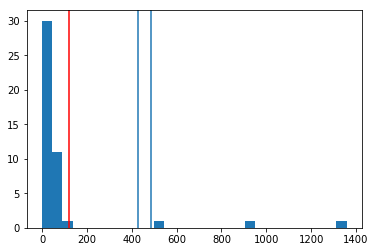

In [14]:
plt.hist(dx,bins=30)
plt.axvline(2*np.std(dx))
plt.axvline(np.percentile(dx,95))
plt.axvline(120,color='r')

In [15]:
np.percentile(dx,75)-np.percentile(dx,25)

34.732220128700135

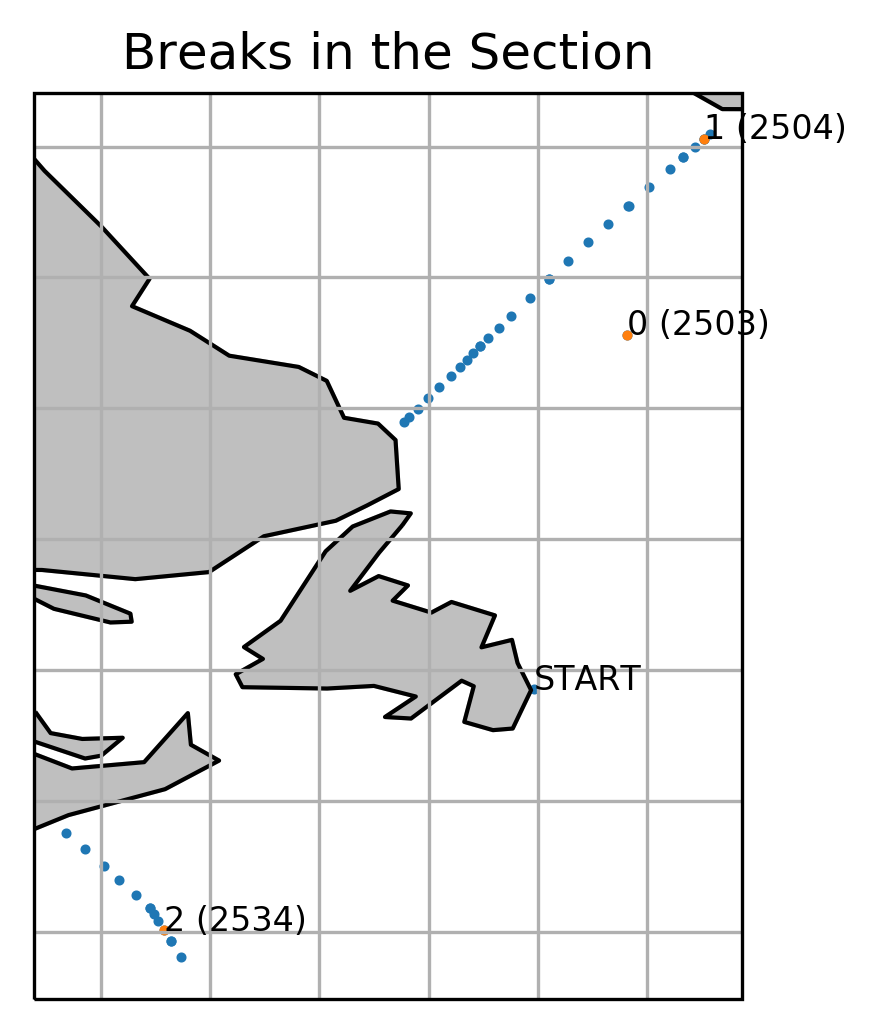

In [16]:
import cartopy as cart

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=cart.crs.PlateCarree())

ax.set_title('Breaks in the Section')
C = ax.scatter(lon,lat, transform=cart.crs.PlateCarree(),s=2)
C = ax.scatter(lon[break_inds],lat[break_inds], transform=cart.crs.PlateCarree(),s=2)

plt.text(lon.values[0], lat.values[0],'START',
             transform = cart.crs.PlateCarree(),
             fontsize=8)

for ind,break_ind in enumerate(break_inds):
    plt.text(lon[break_ind], lat[break_ind],f'{ind} ({break_ind})',transform = cart.crs.PlateCarree(),
             fontsize=8)


ax.add_feature(cart.feature.LAND, facecolor='0.75')
ax.coastlines()
gl = ax.gridlines()
# plt.savefig(f'{line}_{year}_no_qc.png')

In [17]:
new_lat,new_lon = clean_section(lat,lon)

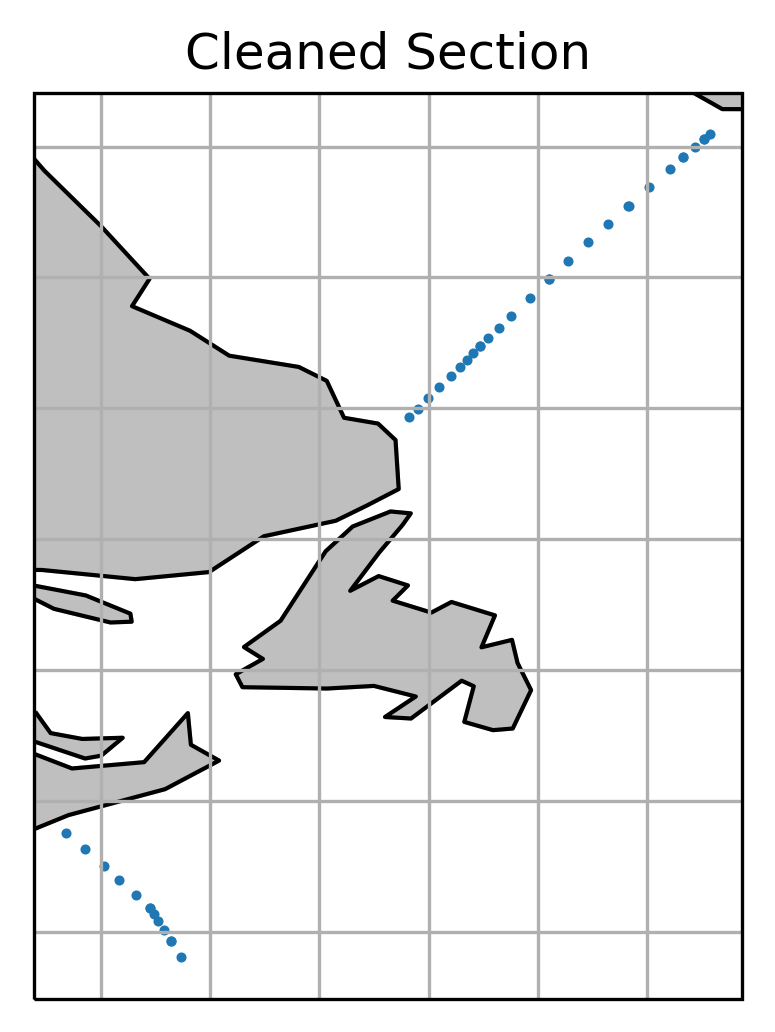

In [18]:
import cartopy as cart

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=cart.crs.PlateCarree())

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()
ax.set_title('Cleaned Section')

C = ax.scatter(new_lon,new_lat, transform=cart.crs.PlateCarree(),s=2)

ax.add_feature(cart.feature.LAND, facecolor='0.75')
ax.coastlines()
gl = ax.gridlines()
# plt.savefig(f'{line}_{year}_no_qc.png')

In [19]:
break_inds = identify_breaks(new_lat,new_lon,pct=95)

TypeError: identify_breaks() got an unexpected keyword argument 'pct'

In [ ]:
import cartopy as cart

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=cart.crs.PlateCarree())

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()
ax.set_title('Cleaned Section')


C = ax.scatter(new_lon,new_lat, transform=cart.crs.PlateCarree(),s=2)
# C = ax.scatter(new_lon[break_inds],new_lat[break_inds], transform=cart.crs.PlateCarree(),s=2)

for ind,break_ind in enumerate(break_inds):
    ax.scatter(new_lon.values[break_ind],new_lat.values[break_ind],
               transform=cart.crs.PlateCarree(),
               s=2,
               color='tab:orange')
    
    plt.text(new_lon.values[break_ind], new_lat.values[break_ind],f'{ind} ({break_ind})',
             transform = cart.crs.PlateCarree(),
             fontsize=8)
    
ax.scatter(new_lon.values[28],new_lat.values[28],
               transform=cart.crs.PlateCarree(),
               s=2,
               color='tab:green')

ax.add_feature(cart.feature.LAND, facecolor='0.75')
ax.coastlines()
gl = ax.gridlines()
# plt.savefig(f'{line}_{year}_no_qc.png')

In [ ]:
coords_new = pd.DataFrame()

for cruise_id in expc['ID']:

    cruise = glodap[glodap['cruise']==cruise_id]
    cruise = cruise.groupby('station').mean()
    
    year = cruise.reset_index().year
    month = cruise.reset_index().month
    lon = cruise.reset_index().longitude
    lat = cruise.reset_index().latitude
    cid = cruise.reset_index().cruise
    
    new_lat,new_lon = clean_section(lat,lon)
    cid = cid.loc[0:len(new_lat)-1]
    new_lat.index = cid.index
    new_lon.index = cid.index
    
    tem = pd.concat([cid,new_lat,new_lon,month,year],axis=1).reset_index()
    coords_new = pd.concat([coords_new,tem])

In [ ]:
coords_new = coords_new.reset_index()

In [ ]:
coords_new = coords_new.drop(['level_0','index'],axis=1)

In [ ]:
coords_new.to_csv('GLODAPv2.2019_COORDS.csv')

In [ ]:
coords_new